# Final Project - Reinforcements Learning - Ex1

---

<img src="https://play-lh.googleusercontent.com/e_oKlKPISbgdzut1H9opevS7-LTB8-8lsmpCdMkhlnqFenZhpjxbLmx7l158-xQQCIY">

Full Notebook:
### https://colab.research.google.com/drive/1umfxWIoivhACC9YcWRZIxINsZch9JEaC?usp=sharing

# Installs

In [ ]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install gym
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install gym_sokoban
!pip install stable-baselines3[extra]
!git clone https://github.com/avivg7/sokoban-so.git
!unzip /content/sokoban-so/Compress.zip
!git clone https://github.com/daniel-litebc/Intro_to_Reinforcement-Learning-Final_Submission.git


# Imports

In [ ]:
import numpy as np
import gym
from gym import logger as gymlogger
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only
from soko_pap import *
import glob
import io
import base64
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame
import pyvirtualdisplay
import imageio
import IPython
import time
import torch
import torch.nn as nn
import torch.optim as optim
from collections import namedtuple, deque
import torch.nn.functional as F
from itertools import count
from stable_baselines3 import PPO
from tqdm import tqdm
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


In [ ]:
assert torch.cuda.is_available()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Display utils
The cell below contains the video display configuration. No need to make changes here.

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

Function - given an environment it will print us the details about observation, actions, agent's position and boxes locations

In [ ]:
def print_env_det(env):
  print(f'Observation space: {env.observation_space}'
      f'\nAction space: {env.action_space}'
      f'\nPlayer position:{env.player_position}'
      f'\nBox location: {find_box_location(env)}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Function - given an environment it will return the indexes position and boxes locations

In [ ]:
def find_box_location(env):
    idx = np.argmax(env.room_state == 4)
    if env.room_state.flat[idx] == 4:
        return np.unravel_index(idx, env.room_state.shape)
    return None

## EX1 - FIX SCENARIO -  PUSH & PULL - ONE BOX

In [ ]:
#=============== DO NOT DELETE ===============
random.seed(2)
sok = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=1 ,max_steps=500)
# ============================================

#Utils

In [ ]:
def conv2d_size_out(size, kernel_size=5, stride=2):
    return (size - (kernel_size - 1) - 1) // stride + 1

h, w, c = sok.observation_space.shape

# Capture the initial configuration for fixed environment (Ex1) and reset env method to use after every episode
initial_room_state = sok.room_state.copy()
initial_room_fixed = sok.room_fixed.copy()
initial_player_position = sok.player_position.copy()
initial_box_position = find_box_location(sok)


def reset_to_initial(env, initial_room_state, initial_room_fixed, initial_player_position, initial_box_position):
    env.room_state = initial_room_state.copy()
    env.room_fixed = initial_room_fixed.copy()
    env.player_position = initial_player_position.copy()

    env.room_state[env.room_state == 4] = 2
    env.room_state[initial_box_position] = 4

    return env.render(mode='rgb_array')


def save_checkpoint(filename, policy_model):
    checkpoint = {
        'policy_model_state_dict': policy_model.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(filename, policy_model, target_model):
    checkpoint = torch.load(filename)
    policy_model.load_state_dict(checkpoint['policy_model_state_dict'])
    target_model.load_state_dict(policy_model.state_dict())
    target_model.eval()


def plot_model_performance(mean_rewards, mean_lengths):
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.plot(mean_rewards)
  plt.title('Mean Episodic Reward')
  plt.xlabel('Episode')
  plt.ylabel('Mean Reward')

  plt.subplot(1, 2, 2)
  plt.plot(mean_lengths)
  plt.title('Mean Episodic Length')
  plt.xlabel('Episode')
  plt.ylabel('Mean Length')

  plt.show()

#DQN Model

In [ ]:
# Calculate the dimensions after passing through all the convolutional layers
convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
linear_input_size = convw * convh * 32  # 32 is the output channel size of the last conv layer

class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.head = nn.Linear(linear_input_size, outputs)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

#Experience Replay

In [ ]:
Experience = namedtuple('Experience', ('state', 'action', 'next_state', 'reward', 'done'))
class ReplayMemory:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(Experience(*args))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

#Training

In [ ]:
# Hyperparameters
BATCH_SIZE = 256
GAMMA = 0.95       #was 0.999
EPS_START = 1.0    # was 0.9
EPS_END = 0.1      # was 0.05
EPS_DECAY = 20000  #was 10,000
TARGET_UPDATE = 5

# Bad way to update epsilon
steps_done = 0

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Create the DQN and target network
n_actions = sok.action_space.n
policy_net = DQN(h, w, n_actions).to(device)
target_net = DQN(h, w, n_actions).to(device)
# load_checkpoint("DQN-policy_net-v1-ep20", policy_net, target_net)
policy_net.load_state_dict(torch.load('DQN-policy_net-v1-ep20'))
# Optimizer and Memory
optimizer = optim.RMSprop(policy_net.parameters(), lr=0.001)
memory = ReplayMemory(10000)

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Experience(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [ ]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

In [ ]:
def train_loop(policy_net, target_net, optimizer, memory, max_steps_per_episode=500, num_episodes=100):

  total_rewards = 0
  total_lengths = 0
  mean_rewards = []
  mean_lengths = []

  for i_episode in tqdm(range(num_episodes)):

    episode_reward = 0.0

    state_array = reset_to_initial(sok, initial_room_state, initial_room_fixed, initial_player_position, initial_box_position)
    state = torch.tensor(state_array.transpose(2, 0, 1), device=device, dtype=torch.float32).unsqueeze(0)

    previous_player_position = None

    # Save once every 10 episodes
    if (i_episode + 1) % 10 == 0:
      save_checkpoint("DQN-checkpoint-v1-ep" + str(i_episode), policy_net)

    for t in range(max_steps_per_episode):
      action = select_action(state)
      next_state, reward, done, _ = sok.step(action.item())

      # Check if the episode ended and was successful
      if done and t < 250:
        reward += 10

      # Check if the box has not moved and penalize
      if not info['action.moved_box']:
          reward -= 0.1  # Define this penalty value as needed
      else:
          reward += 0.1

      current_player_position = sok.player_position
      if np.array_equal(previous_player_position, current_player_position):
        reward -= 0.1  # Define this penalty value as needed


      previous_player_position = current_player_position  # Update the previous player position for the next step
      episode_reward += reward

      next_state = torch.tensor(next_state.transpose(2, 0, 1), device=device, dtype=torch.float32).unsqueeze(0)
      reward = torch.tensor([reward], device=device)
      memory.push(state, action, next_state, reward, done)
      state = next_state

      optimize_model()
      if done:
          break

    total_rewards += episode_reward
    total_lengths += t + 1

    mean_episodic_reward = total_rewards / (i_episode + 1)
    mean_episodic_length = total_lengths / (i_episode + 1)

    mean_rewards.append(mean_episodic_reward)
    mean_lengths.append(mean_episodic_length)

    print()
    print("=" * 20 + "Training Progress " + "Episode " + str(i_episode + 1) + "=" * 20)
    print("Mean Episode Reward: ", mean_episodic_reward)
    print("Mean Episode Length: ", mean_episodic_length)
    print(f"Current Episode Reward: {episode_reward}")
    print(f"Current Episode Length: {t + 1}")

    print()



    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

  return mean_rewards, mean_lengths

# Train Model

In [ ]:
mean_rewards, mean_lengths = train_loop(policy_net, target_net, optimizer, memory, max_steps_per_episode=500, num_episodes=500)

  0%|          | 1/500 [00:09<1:17:12,  9.28s/it]


====================Training Progress Episode 1====================
Mean Episode Reward:  -120.40000000000032
Mean Episode Length:  500.0
Current Episode Reward: -120.40000000000032
Current Episode Length: 500



  0%|          | 2/500 [00:26<1:56:31, 14.04s/it]


====================Training Progress Episode 2====================
Mean Episode Reward:  -118.8000000000003
Mean Episode Length:  500.0
Current Episode Reward: -117.20000000000029
Current Episode Length: 500



  1%|          | 3/500 [00:43<2:08:24, 15.50s/it]


====================Training Progress Episode 3====================
Mean Episode Reward:  -117.70000000000033
Mean Episode Length:  500.0
Current Episode Reward: -115.50000000000041
Current Episode Length: 500



  1%|          | 4/500 [01:00<2:13:16, 16.12s/it]


====================Training Progress Episode 4====================
Mean Episode Reward:  -117.47500000000034
Mean Episode Length:  500.0
Current Episode Reward: -116.80000000000037
Current Episode Length: 500



  1%|          | 5/500 [01:15<2:09:41, 15.72s/it]


====================Training Progress Episode 5====================
Mean Episode Reward:  -112.8400000000003
Mean Episode Length:  488.8
Current Episode Reward: -94.30000000000018
Current Episode Length: 444



  1%|          | 6/500 [01:18<1:33:31, 11.36s/it]


====================Training Progress Episode 6====================
Mean Episode Reward:  -94.01666666666692
Mean Episode Length:  421.1666666666667
Current Episode Reward: 0.09999999999999432
Current Episode Length: 83



  1%|▏         | 7/500 [01:24<1:18:37,  9.57s/it]


====================Training Progress Episode 7====================
Mean Episode Reward:  -83.60000000000022
Mean Episode Length:  386.0
Current Episode Reward: -21.10000000000006
Current Episode Length: 175



  2%|▏         | 8/500 [01:35<1:22:42, 10.09s/it]


====================Training Progress Episode 8====================
Mean Episode Reward:  -81.50000000000021
Mean Episode Length:  378.875
Current Episode Reward: -66.80000000000022
Current Episode Length: 329



  2%|▏         | 9/500 [01:53<1:40:36, 12.29s/it]


====================Training Progress Episode 9====================
Mean Episode Reward:  -85.86666666666687
Mean Episode Length:  392.3333333333333
Current Episode Reward: -120.80000000000018
Current Episode Length: 500



  2%|▏         | 10/500 [02:00<1:29:04, 10.91s/it]


====================Training Progress Episode 10====================
Mean Episode Reward:  -80.82000000000019
Mean Episode Length:  375.9
Current Episode Reward: -35.40000000000006
Current Episode Length: 228



  2%|▏         | 11/500 [02:13<1:32:12, 11.31s/it]


====================Training Progress Episode 11====================
Mean Episode Reward:  -79.90000000000022
Mean Episode Length:  374.3636363636364
Current Episode Reward: -70.70000000000033
Current Episode Length: 359



  2%|▏         | 12/500 [02:30<1:46:05, 13.04s/it]


====================Training Progress Episode 12====================
Mean Episode Reward:  -82.93333333333355
Mean Episode Length:  384.8333333333333
Current Episode Reward: -116.30000000000032
Current Episode Length: 500



  3%|▎         | 13/500 [02:47<1:55:51, 14.27s/it]


====================Training Progress Episode 13====================
Mean Episode Reward:  -85.3461538461541
Mean Episode Length:  393.6923076923077
Current Episode Reward: -114.30000000000045
Current Episode Length: 500



  3%|▎         | 14/500 [02:51<1:30:43, 11.20s/it]


====================Training Progress Episode 14====================
Mean Episode Reward:  -79.7071428571431
Mean Episode Length:  374.2142857142857
Current Episode Reward: -6.399999999999988
Current Episode Length: 121



  3%|▎         | 15/500 [02:55<1:14:12,  9.18s/it]


====================Training Progress Episode 15====================
Mean Episode Reward:  -75.10000000000021
Mean Episode Length:  358.1333333333333
Current Episode Reward: -10.599999999999977
Current Episode Length: 133



  3%|▎         | 16/500 [03:00<1:02:10,  7.71s/it]


====================Training Progress Episode 16====================
Mean Episode Reward:  -70.9437500000002
Mean Episode Length:  343.5
Current Episode Reward: -8.599999999999984
Current Episode Length: 124



  3%|▎         | 17/500 [03:07<1:00:55,  7.57s/it]


====================Training Progress Episode 17====================
Mean Episode Reward:  -68.48235294117666
Mean Episode Length:  335.94117647058823
Current Episode Reward: -29.10000000000006
Current Episode Length: 215



  4%|▎         | 18/500 [03:11<52:13,  6.50s/it]  


====================Training Progress Episode 18====================
Mean Episode Reward:  -65.02222222222241
Mean Episode Length:  323.6111111111111
Current Episode Reward: -6.199999999999985
Current Episode Length: 114



  4%|▍         | 19/500 [03:21<59:48,  7.46s/it]


====================Training Progress Episode 19====================
Mean Episode Reward:  -64.47894736842123
Mean Episode Length:  321.63157894736844
Current Episode Reward: -54.700000000000145
Current Episode Length: 286



  4%|▍         | 20/500 [03:25<51:42,  6.46s/it]


====================Training Progress Episode 20====================
Mean Episode Reward:  -61.65000000000017
Mean Episode Length:  311.55
Current Episode Reward: -7.899999999999984
Current Episode Length: 120



  4%|▍         | 21/500 [03:42<1:16:46,  9.62s/it]


====================Training Progress Episode 21====================
Mean Episode Reward:  -64.12857142857162
Mean Episode Length:  320.5238095238095
Current Episode Reward: -113.7000000000005
Current Episode Length: 500



  4%|▍         | 22/500 [03:59<1:34:19, 11.84s/it]


====================Training Progress Episode 22====================
Mean Episode Reward:  -66.39090909090929
Mean Episode Length:  328.6818181818182
Current Episode Reward: -113.90000000000038
Current Episode Length: 500



  5%|▍         | 23/500 [04:04<1:17:50,  9.79s/it]


====================Training Progress Episode 23====================
Mean Episode Reward:  -64.09130434782627
Mean Episode Length:  320.7391304347826
Current Episode Reward: -13.499999999999986
Current Episode Length: 146



  5%|▍         | 24/500 [04:05<57:29,  7.25s/it]  


====================Training Progress Episode 24====================
Mean Episode Reward:  -60.95833333333351
Mean Episode Length:  309.0
Current Episode Reward: 11.099999999999998
Current Episode Length: 39



  5%|▌         | 25/500 [04:22<1:20:39, 10.19s/it]


====================Training Progress Episode 25====================
Mean Episode Reward:  -63.06800000000019
Mean Episode Length:  316.64
Current Episode Reward: -113.70000000000047
Current Episode Length: 500



  5%|▌         | 26/500 [04:39<1:36:52, 12.26s/it]


====================Training Progress Episode 26====================
Mean Episode Reward:  -65.25769230769251
Mean Episode Length:  323.6923076923077
Current Episode Reward: -120.00000000000017
Current Episode Length: 500



  5%|▌         | 27/500 [04:48<1:29:06, 11.30s/it]


====================Training Progress Episode 27====================
Mean Episode Reward:  -64.86666666666686
Mean Episode Length:  321.6296296296296
Current Episode Reward: -54.70000000000006
Current Episode Length: 268



  6%|▌         | 28/500 [05:05<1:42:37, 13.05s/it]


====================Training Progress Episode 28====================
Mean Episode Reward:  -66.95000000000019
Mean Episode Length:  328.0
Current Episode Reward: -123.20000000000019
Current Episode Length: 500



  6%|▌         | 29/500 [05:18<1:42:20, 13.04s/it]


====================Training Progress Episode 29====================
Mean Episode Reward:  -67.65172413793121
Mean Episode Length:  329.86206896551727
Current Episode Reward: -87.30000000000003
Current Episode Length: 382



  6%|▌         | 30/500 [05:26<1:28:45, 11.33s/it]


====================Training Progress Episode 30====================
Mean Episode Reward:  -66.40000000000018
Mean Episode Length:  326.1
Current Episode Reward: -30.100000000000108
Current Episode Length: 217



  6%|▌         | 31/500 [05:43<1:42:21, 13.09s/it]


====================Training Progress Episode 31====================
Mean Episode Reward:  -67.90645161290341
Mean Episode Length:  331.7096774193548
Current Episode Reward: -113.10000000000048
Current Episode Length: 500



  6%|▋         | 32/500 [05:59<1:48:00, 13.85s/it]


====================Training Progress Episode 32====================
Mean Episode Reward:  -68.6531250000002
Mean Episode Length:  335.6875
Current Episode Reward: -91.80000000000051
Current Episode Length: 459



  7%|▋         | 33/500 [06:16<1:55:10, 14.80s/it]


====================Training Progress Episode 33====================
Mean Episode Reward:  -69.8848484848487
Mean Episode Length:  340.6666666666667
Current Episode Reward: -109.30000000000062
Current Episode Length: 500



  7%|▋         | 34/500 [06:33<2:00:25, 15.51s/it]


====================Training Progress Episode 34====================
Mean Episode Reward:  -71.02647058823553
Mean Episode Length:  345.3529411764706
Current Episode Reward: -108.70000000000077
Current Episode Length: 500



  7%|▋         | 35/500 [06:50<2:03:36, 15.95s/it]


====================Training Progress Episode 35====================
Mean Episode Reward:  -72.08285714285739
Mean Episode Length:  349.77142857142854
Current Episode Reward: -108.00000000000077
Current Episode Length: 500



  7%|▋         | 36/500 [07:07<2:05:51, 16.27s/it]


====================Training Progress Episode 36====================
Mean Episode Reward:  -73.18888888888915
Mean Episode Length:  353.94444444444446
Current Episode Reward: -111.90000000000074
Current Episode Length: 500



  7%|▋         | 37/500 [07:24<2:07:29, 16.52s/it]


====================Training Progress Episode 37====================
Mean Episode Reward:  -74.32702702702728
Mean Episode Length:  357.8918918918919
Current Episode Reward: -115.30000000000025
Current Episode Length: 500



  8%|▊         | 38/500 [07:30<1:42:27, 13.31s/it]


====================Training Progress Episode 38====================
Mean Episode Reward:  -72.8368421052634
Mean Episode Length:  353.0
Current Episode Reward: -17.69999999999999
Current Episode Length: 172



  8%|▊         | 39/500 [07:47<1:51:03, 14.45s/it]


====================Training Progress Episode 39====================
Mean Episode Reward:  -74.01025641025666
Mean Episode Length:  356.7692307692308
Current Episode Reward: -118.60000000000022
Current Episode Length: 500



  8%|▊         | 40/500 [08:04<1:56:44, 15.23s/it]


====================Training Progress Episode 40====================
Mean Episode Reward:  -75.20000000000024
Mean Episode Length:  360.35
Current Episode Reward: -121.60000000000004
Current Episode Length: 500



  8%|▊         | 41/500 [08:21<2:00:37, 15.77s/it]


====================Training Progress Episode 41====================
Mean Episode Reward:  -76.23414634146366
Mean Episode Length:  363.7560975609756
Current Episode Reward: -117.60000000000026
Current Episode Length: 500



  8%|▊         | 42/500 [08:38<2:03:47, 16.22s/it]


====================Training Progress Episode 42====================
Mean Episode Reward:  -76.9976190476193
Mean Episode Length:  367.0
Current Episode Reward: -108.30000000000067
Current Episode Length: 500



  9%|▊         | 43/500 [08:55<2:05:19, 16.45s/it]


====================Training Progress Episode 43====================
Mean Episode Reward:  -77.78604651162817
Mean Episode Length:  370.09302325581393
Current Episode Reward: -110.9000000000005
Current Episode Length: 500



  9%|▊         | 43/500 [09:09<1:37:15, 12.77s/it]


KeyboardInterrupt: ignored

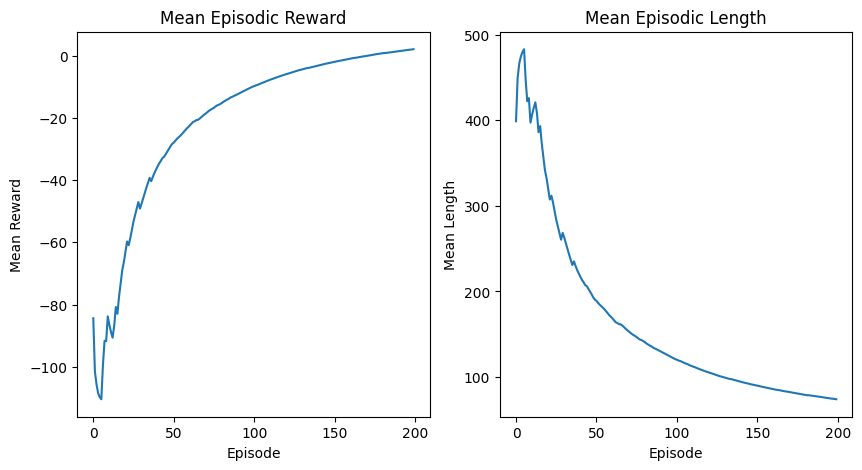

In [ ]:
plot_model_performance(mean_rewards, mean_lengths)